In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import math
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer
from sklearn.cross_validation import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib
import scipy as sp
from scipy.optimize import *

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/anantagarwal/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/anantagarwal/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import metrics

In [6]:
train = pd.read_csv('train_ZoGVYWq.csv')
test = pd.read_csv('test_66516Ee.csv')

### Data preprocessing

In [7]:
display(train.head(), test.head())

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [8]:
display(train.shape, test.shape)

(79853, 13)

(34224, 12)

In [9]:
display(train.dtypes, test.dtypes)

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
renewal                               int64
dtype: object

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
dtype: object

#### One-hot encoding

In [10]:
#integer encode
label_encoder = LabelEncoder()
#For training data
sourcing_encoded_train = label_encoder.fit_transform(train.sourcing_channel)
res_encoded_train = label_encoder.fit_transform(train.residence_area_type)
#For test data
sourcing_encoded_test = label_encoder.fit_transform(test.sourcing_channel)
res_encoded_test = label_encoder.fit_transform(test.residence_area_type)
#Display
display(sourcing_encoded_train, res_encoded_train, sourcing_encoded_test, res_encoded_test)

array([2, 0, 2, ..., 0, 0, 0])

array([1, 1, 0, ..., 0, 0, 1])

array([0, 0, 1, ..., 1, 0, 0])

array([0, 1, 1, ..., 0, 1, 1])

In [11]:
#binary encode
onehot_encoder = OneHotEncoder(sparse=False)
#reshaping
sourcing_encoded_train = sourcing_encoded_train.reshape(len(sourcing_encoded_train), 1)
res_encoded_train = res_encoded_train.reshape(len(res_encoded_train), 1)
sourcing_encoded_test = sourcing_encoded_test.reshape(len(sourcing_encoded_test), 1)
res_encoded_test = res_encoded_test.reshape(len(res_encoded_test), 1)
#one-hot encoding
sourcing_onehot_train = onehot_encoder.fit_transform(sourcing_encoded_train)
res_onehot_train = onehot_encoder.fit_transform(res_encoded_train)
sourcing_onehot_test = onehot_encoder.fit_transform(sourcing_encoded_test)
res_onehot_test = onehot_encoder.fit_transform(res_encoded_test)

In [12]:
#Display shapes
sourcing_onehot_train.shape, res_onehot_train.shape, sourcing_onehot_test.shape, res_onehot_test.shape

((79853, 5), (79853, 2), (34224, 5), (34224, 2))

In [13]:
#Convert to pandas dataframe
sourcing_df_train = pd.DataFrame(sourcing_onehot_train, columns = ['sourcing' + str(i) for i in range(sourcing_onehot_train.shape[1])])
res_df_train = pd.DataFrame(res_onehot_train, columns = ['res' + str(i) for i in range(res_onehot_train.shape[1])])
sourcing_df_test = pd.DataFrame(sourcing_onehot_test, columns = ['sourcing' + str(i) for i in range(sourcing_onehot_test.shape[1])])
res_df_test = pd.DataFrame(res_onehot_test, columns = ['res' + str(i) for i in range(res_onehot_test.shape[1])])

In [14]:
display (sourcing_df_train.head(), res_df_train.head(), sourcing_df_test.head(), res_df_test.head())

,sourcing0,sourcing1,sourcing2,sourcing3,sourcing4
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


,res0,res1
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


,sourcing0,sourcing1,sourcing2,sourcing3,sourcing4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


,res0,res1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0


In [15]:
#Concatenating one-hot encodings and dropping categorical columns
train_concat = pd.concat([train, sourcing_df_train, res_df_train], axis=1)
test_concat = pd.concat([test, sourcing_df_test, res_df_test], axis=1)
train_concat = train_concat.drop(columns = ['sourcing_channel', 'residence_area_type'])
test_concat = test_concat.drop(columns = ['sourcing_channel', 'residence_area_type'])

#### Missing values

In [16]:
display(np.sum(train_concat.isna())[np.sum(train_concat.isna()) != 0], \
        np.sum(test.isna())[np.sum(test.isna()) != 0])

Count_3-6_months_late               97
Count_6-12_months_late              97
Count_more_than_12_months_late      97
application_underwriting_score    2974
dtype: int64

Count_3-6_months_late               31
Count_6-12_months_late              31
Count_more_than_12_months_late      31
application_underwriting_score    1323
dtype: int64

In [17]:
#Imputing mean
mean_aus = np.mean(train_concat.application_underwriting_score)
train_concat.application_underwriting_score = train_concat.application_underwriting_score.fillna(mean_aus)
test_concat.application_underwriting_score = test_concat.application_underwriting_score.fillna(mean_aus)

In [18]:
#Imputing median
imp_med = Imputer(strategy='median')
train_columns = train_concat.columns
test_columns = test_concat.columns
train_prepoc = imp_med.fit_transform(train_concat)
test_prepoc = imp_med.fit_transform(test_concat)

In [19]:
train_prepoc = pd.DataFrame(train_prepoc, columns=train_columns)
test_prepoc = pd.DataFrame(test_prepoc, columns=test_columns)

In [20]:
display(train_prepoc.head(), test_prepoc.head())

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal,sourcing0,sourcing1,sourcing2,sourcing3,sourcing4,res0,res1
0,110936.0,0.429,12058.0,355060.0,0.0,0.0,0.0,99.02,13.0,3300.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,41492.0,0.010,21546.0,315150.0,0.0,0.0,0.0,99.89,21.0,18000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,31300.0,0.917,17531.0,84140.0,2.0,3.0,1.0,98.69,7.0,3300.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,19415.0,0.049,15341.0,250510.0,0.0,0.0,0.0,99.57,9.0,9600.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,99379.0,0.052,31400.0,198680.0,0.0,0.0,0.0,99.87,12.0,9600.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing0,sourcing1,sourcing2,sourcing3,sourcing4,res0,res1
0,649.0,0.001,27384.0,51150.0,0.0,0.0,0.0,99.890000,7.0,3300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,81136.0,0.124,23735.0,285140.0,0.0,0.0,0.0,98.930000,19.0,11700.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,70762.0,1.000,17170.0,186030.0,0.0,0.0,0.0,99.067291,2.0,11700.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,53935.0,0.198,16068.0,123540.0,0.0,0.0,0.0,99.000000,11.0,5400.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,15476.0,0.041,10591.0,200020.0,1.0,0.0,0.0,99.170000,14.0,9600.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
#Verifying for NAs
display(np.sum(train_prepoc.isna())[np.sum(train_prepoc.isna()) != 0], \
        np.sum(test_prepoc.isna())[np.sum(test_prepoc.isna()) != 0])

Series([], dtype: int64)

Series([], dtype: int64)

#### Split into training and development sets

In [22]:
train_prepoc = train_prepoc.set_index('id')
test_prepoc = test_prepoc.set_index('id')

In [23]:
X = train_prepoc.loc[:, filter(lambda x: x not in ['renewal'], train_prepoc.columns)]
y = train_prepoc.loc[:,['renewal']]
X_test = test_prepoc

In [24]:
seed = 1
dev_size = 0.25
X_train, X_dev, y_train, y_dev = train_test_split(X,y,test_size = dev_size, random_state = seed)

In [25]:
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape

((59889, 16), (59889, 1), (19964, 16), (19964, 1), (34224, 16))

In [26]:
#Converting to 1D array
y_train = y_train.squeeze()
y_dev = y_dev.squeeze()

### Implement XGBoost

In [30]:
def model_fit_xg(alg, X_train, y_train, featureImportance = True, performCV = True, early_stopping_rounds=50):
    #fit model to training data
    alg.fit(X_train, y_train, eval_metric='auc')
    #predict on training set
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:,1]
    
    print("Accuracy: %.4g" % accuracy_score(y_train.values, train_predictions) )
    print("AUC score (train): %f" % roc_auc_score(y_train, train_predprob))
    
    if performCV:
        #kfold = StratifiedKFold(n_splits=10, random_state=1)
        xgb_par = alg.get_xgb_params()
        train_xg = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_par, train_xg, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    if featureImportance:
        feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

Accuracy: 0.9659
AUC score (train): 0.976711


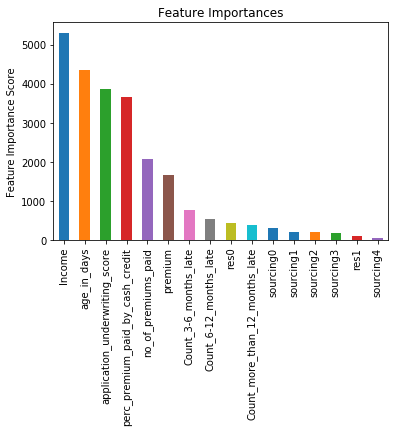

In [31]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_fit_xg(xgb1, X_train, y_train)

In [32]:
print(xgb1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=51,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)


In [98]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83882, std: 0.00250, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83900, std: 0.00247, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83895, std: 0.00254, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84054, std: 0.00332, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84096, std: 0.00347, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84042, std: 0.00315, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83723, std: 0.00309, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83790, std: 0.00320, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83813, std: 0.00325, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83220, std: 0.00237, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83409, std: 0.00332, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83501, std: 0.00257, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 3

In [99]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83991, std: 0.00295, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.84028, std: 0.00319, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.84039, std: 0.00303, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.84054, std: 0.00345, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.84096, std: 0.00347, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84091, std: 0.00326, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.83950, std: 0.00356, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.83935, std: 0.00295, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.83981, std: 0.00353, params: {'max_depth': 6, 'min_child_weight': 4}],
 {'max_depth': 5, 'min_child_weight': 3},
 0.8409582425018074)

In [104]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=21, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83783, std: 0.00369, params: {'gamma': 0.0},
  mean: 0.83780, std: 0.00368, params: {'gamma': 0.1},
  mean: 0.83780, std: 0.00369, params: {'gamma': 0.2},
  mean: 0.83781, std: 0.00369, params: {'gamma': 0.3},
  mean: 0.83779, std: 0.00370, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8378263552077779)

Accuracy: 0.9618
AUC score (train): 0.965556


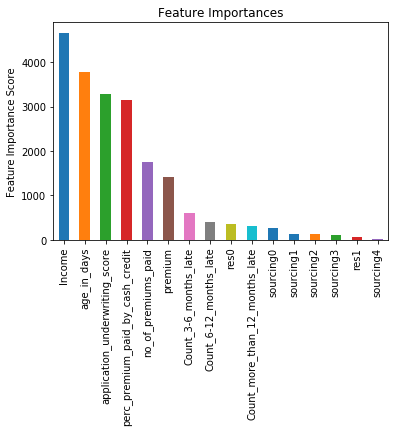

In [33]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_fit_xg(xgb2, X_train, y_train)

In [34]:
print(xgb2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=66,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)


In [110]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=66, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83991, std: 0.00343, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83997, std: 0.00348, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.84045, std: 0.00259, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.83997, std: 0.00252, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.83959, std: 0.00279, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.84020, std: 0.00347, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.84024, std: 0.00278, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.84021, std: 0.00275, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.84055, std: 0.00272, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.84037, std: 0.00346, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.84073, std: 0.00308, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.84037, std: 0.00327, params: {'subsample': 0.9, 'colsample_bytree'

In [111]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=66, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=66,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.85, 0.9, 0.95]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [112]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84004, std: 0.00292, params: {'subsample': 0.75, 'colsample_bytree': 0.85},
  mean: 0.84028, std: 0.00278, params: {'subsample': 0.8, 'colsample_bytree': 0.85},
  mean: 0.84009, std: 0.00329, params: {'subsample': 0.85, 'colsample_bytree': 0.85},
  mean: 0.84054, std: 0.00286, params: {'subsample': 0.75, 'colsample_bytree': 0.9},
  mean: 0.84075, std: 0.00335, params: {'subsample': 0.8, 'colsample_bytree': 0.9},
  mean: 0.84033, std: 0.00323, params: {'subsample': 0.85, 'colsample_bytree': 0.9},
  mean: 0.84036, std: 0.00278, params: {'subsample': 0.75, 'colsample_bytree': 0.95},
  mean: 0.84029, std: 0.00341, params: {'subsample': 0.8, 'colsample_bytree': 0.95},
  mean: 0.84008, std: 0.00274, params: {'subsample': 0.85, 'colsample_bytree': 0.95}],
 {'colsample_bytree': 0.9, 'subsample': 0.8},
 0.8407524536608533)

In [113]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=66, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train,y_train)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84006, std: 0.00314, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05},
  mean: 0.84029, std: 0.00316, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01},
  mean: 0.84011, std: 0.00309, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1},
  mean: 0.84075, std: 0.00335, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.84126, std: 0.00330, params: {'reg_alpha': 1e-05, 'reg_lambda': 100},
  mean: 0.84048, std: 0.00297, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05},
  mean: 0.84035, std: 0.00317, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: 0.84005, std: 0.00320, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: 0.84018, std: 0.00313, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.84134, std: 0.00335, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: 0.84018, std: 0.00297, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05},
  mean: 0.84005, std: 0.00339, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: 0.84048, std: 0.00285, params: {'reg

In [118]:
param_test7 = {
 'reg_alpha':[1e-5, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda':[1,3,5,7,10]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=66, max_depth=5,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_train,y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.84075, std: 0.00335, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.84073, std: 0.00294, params: {'reg_alpha': 1e-05, 'reg_lambda': 3},
  mean: 0.84151, std: 0.00314, params: {'reg_alpha': 1e-05, 'reg_lambda': 5},
  mean: 0.84138, std: 0.00308, params: {'reg_alpha': 1e-05, 'reg_lambda': 7},
  mean: 0.84141, std: 0.00296, params: {'reg_alpha': 1e-05, 'reg_lambda': 10},
  mean: 0.84065, std: 0.00349, params: {'reg_alpha': 0.001, 'reg_lambda': 1},
  mean: 0.84103, std: 0.00324, params: {'reg_alpha': 0.001, 'reg_lambda': 3},
  mean: 0.84137, std: 0.00315, params: {'reg_alpha': 0.001, 'reg_lambda': 5},
  mean: 0.84150, std: 0.00295, params: {'reg_alpha': 0.001, 'reg_lambda': 7},
  mean: 0.84126, std: 0.00285, params: {'reg_alpha': 0.001, 'reg_lambda': 10},
  mean: 0.84061, std: 0.00353, params: {'reg_alpha': 0.005, 'reg_lambda': 1},
  mean: 0.84128, std: 0.00301, params: {'reg_alpha': 0.005, 'reg_lambda': 3},
  mean: 0.84149, std: 0.00308, params: {'reg_alpha': 0.005, 'r

Accuracy: 0.9596
AUC score (train): 0.958083


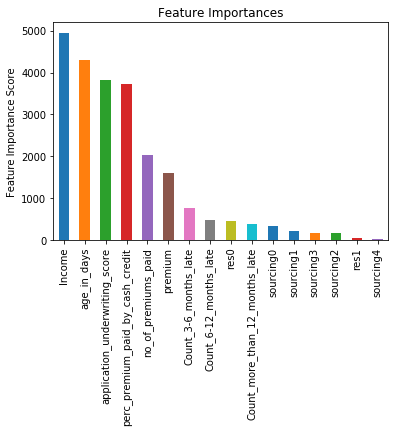

In [35]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0.005,
    reg_lambda=7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_fit_xg(xgb3, X_train, y_train)

In [36]:
print(xgb3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=51,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.005, reg_lambda=7, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8)


In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=15000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0.005,
    reg_lambda=7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model_fit_xg(xgb4, X_train, y_train)

In [ ]:
print(xgb4)

In [125]:
#evaluating model on development set
dev_predictions = xgb3.predict(X_dev)
dev_predprob = xgb3.predict_proba(X_dev)[:,1]
#evaluate predictions
print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9357
AUC score (dev): 0.817382


In [126]:
#evaluating model on development set
dev_predictions = xgb4.predict(X_dev)
dev_predprob = xgb4.predict_proba(X_dev)[:,1]
#evaluate predictions
print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9365
AUC score (dev): 0.832577


### Implement Gradient Boosting

In [84]:
def model_fit_gb(alg, X_train, y_train, featureImportance = True, performCV = True):
    #fit model to training data
    alg.fit(X_train, y_train)
    #predict on training set
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:,1]
    
    print("Accuracy: %.4g" % accuracy_score(y_train.values, train_predictions) )
    print("AUC score (train): %f" % roc_auc_score(y_train, train_predprob))
    
    if performCV:
        #kfold = StratifiedKFold(n_splits=10, random_state=1)
        results = cross_val_score(alg, X_train, y_train, cv=5, scoring='roc_auc')
        print("CV score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % \
              (np.mean(results),np.std(results),np.min(results),np.max(results)))
    
    if featureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [27]:
GB_model = GradientBoostingClassifier()
model_fit_gb(GB_model, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
#Perform grid search
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, min_samples_split=500,
                                                             min_samples_leaf=50, max_depth=8, max_features='sqrt',
                                                             subsample=0.8, random_state=10),
                        param_grid = param_test1, scoring = 'roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)

In [64]:
#Checking output
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83984, std: 0.00470, params: {'n_estimators': 20},
  mean: 0.84001, std: 0.00440, params: {'n_estimators': 30},
  mean: 0.84043, std: 0.00423, params: {'n_estimators': 40},
  mean: 0.84038, std: 0.00381, params: {'n_estimators': 50},
  mean: 0.84056, std: 0.00366, params: {'n_estimators': 60},
  mean: 0.84072, std: 0.00361, params: {'n_estimators': 70},
  mean: 0.84064, std: 0.00324, params: {'n_estimators': 80}],
 {'n_estimators': 70},
 0.8407173668014082)

In [66]:
#Perform grid search for tuning tree-specific parameters
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=70,
                                                               max_features='sqrt', subsample=0.8, random_state=10),
                       param_grid=param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [200, 400, 600, 800, 1000], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [67]:
#Checking output
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83985, std: 0.00365, params: {'min_samples_split': 200, 'max_depth': 5},
  mean: 0.84036, std: 0.00353, params: {'min_samples_split': 400, 'max_depth': 5},
  mean: 0.84015, std: 0.00358, params: {'min_samples_split': 600, 'max_depth': 5},
  mean: 0.84018, std: 0.00350, params: {'min_samples_split': 800, 'max_depth': 5},
  mean: 0.84026, std: 0.00342, params: {'min_samples_split': 1000, 'max_depth': 5},
  mean: 0.84062, std: 0.00314, params: {'min_samples_split': 200, 'max_depth': 7},
  mean: 0.84086, std: 0.00317, params: {'min_samples_split': 400, 'max_depth': 7},
  mean: 0.84102, std: 0.00339, params: {'min_samples_split': 600, 'max_depth': 7},
  mean: 0.84116, std: 0.00354, params: {'min_samples_split': 800, 'max_depth': 7},
  mean: 0.84089, std: 0.00321, params: {'min_samples_split': 1000, 'max_depth': 7},
  mean: 0.83903, std: 0.00268, params: {'min_samples_split': 200, 'max_depth': 9},
  mean: 0.84046, std: 0.00293, params: {'min_samples_split': 400, 'max_depth': 9},
  

In [87]:
#Perform grid search 
param_test3 = {'min_samples_leaf':range(30,250,10)}
gsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=70,
                                                            max_depth=9, min_samples_split=600, max_features='sqrt', subsample=0.8,
                                                            random_state=10),
                       param_grid=param_test3, scoring='roc_auc',n_jobs=4,iid=False,cv=5)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [88]:
#Checking output
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84134, std: 0.00332, params: {'min_samples_leaf': 30},
  mean: 0.84100, std: 0.00360, params: {'min_samples_leaf': 40},
  mean: 0.84119, std: 0.00286, params: {'min_samples_leaf': 50},
  mean: 0.84083, std: 0.00359, params: {'min_samples_leaf': 60},
  mean: 0.84105, std: 0.00294, params: {'min_samples_leaf': 70},
  mean: 0.84098, std: 0.00327, params: {'min_samples_leaf': 80},
  mean: 0.84103, std: 0.00319, params: {'min_samples_leaf': 90},
  mean: 0.84070, std: 0.00330, params: {'min_samples_leaf': 100},
  mean: 0.84108, std: 0.00290, params: {'min_samples_leaf': 110},
  mean: 0.84106, std: 0.00268, params: {'min_samples_leaf': 120},
  mean: 0.84099, std: 0.00282, params: {'min_samples_leaf': 130},
  mean: 0.84104, std: 0.00337, params: {'min_samples_leaf': 140},
  mean: 0.84106, std: 0.00287, params: {'min_samples_leaf': 150},
  mean: 0.84148, std: 0.00310, params: {'min_samples_leaf': 160},
  mean: 0.84125, std: 0.00302, params: {'min_samples_leaf': 170},
  mean: 0.84095, 

Accuracy: 0.9412
AUC score (train): 0.865071
CV score : Mean - 0.8417032 | Std - 0.003029672 | Min - 0.8382036 | Max - 0.8471725


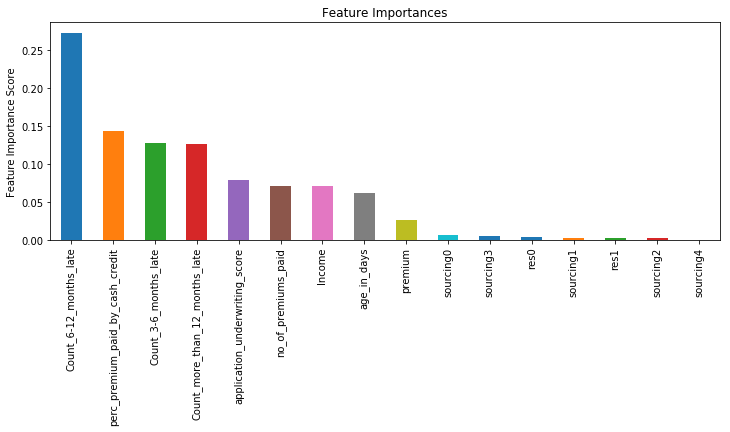

In [94]:
model_fit_gb(gsearch3.best_estimator_, X_train, y_train)

In [96]:
#Perform grid search by tuning max_features
param_test4 = {'max_features':range(2,17,2)}
gsearch4 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=70,
                                                            max_depth=9,min_samples_split=600,
                                                            min_samples_leaf=220, subsample=0.8,
                                                            random_state=10),
                       param_grid = param_test4, scoring='roc_auc', n_jobs=4,iid=False,cv=5)
gsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=220, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [2, 4, 6, 8, 10, 12, 14, 16]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [97]:
#Checking output
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83985, std: 0.00331, params: {'max_features': 2},
  mean: 0.84170, std: 0.00303, params: {'max_features': 4},
  mean: 0.84088, std: 0.00386, params: {'max_features': 6},
  mean: 0.84036, std: 0.00311, params: {'max_features': 8},
  mean: 0.83997, std: 0.00297, params: {'max_features': 10},
  mean: 0.84000, std: 0.00340, params: {'max_features': 12},
  mean: 0.83961, std: 0.00307, params: {'max_features': 14},
  mean: 0.83990, std: 0.00250, params: {'max_features': 16}],
 {'max_features': 4},
 0.8417031780299824)

In [101]:
#Tuning subsample and making models with lower learning rate
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.05, n_estimators=70,
                                                            max_depth=9, min_samples_split=600,
                                                            min_samples_leaf=220, max_features='sqrt',
                                                            random_state=10,subsample=0.8),
                       param_grid=param_test5, scoring='roc_auc', n_jobs=4,iid=False,cv=5)
gsearch5.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=220, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [102]:
#Checking output
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84107, std: 0.00366, params: {'subsample': 0.6},
  mean: 0.84093, std: 0.00375, params: {'subsample': 0.7},
  mean: 0.84162, std: 0.00290, params: {'subsample': 0.75},
  mean: 0.84170, std: 0.00303, params: {'subsample': 0.8},
  mean: 0.84134, std: 0.00292, params: {'subsample': 0.85},
  mean: 0.84106, std: 0.00307, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.8417031780299824)

Accuracy: 0.9417
AUC score (train): 0.865865
CV score : Mean - 0.8414752 | Std - 0.003297689 | Min - 0.8374778 | Max - 0.847277


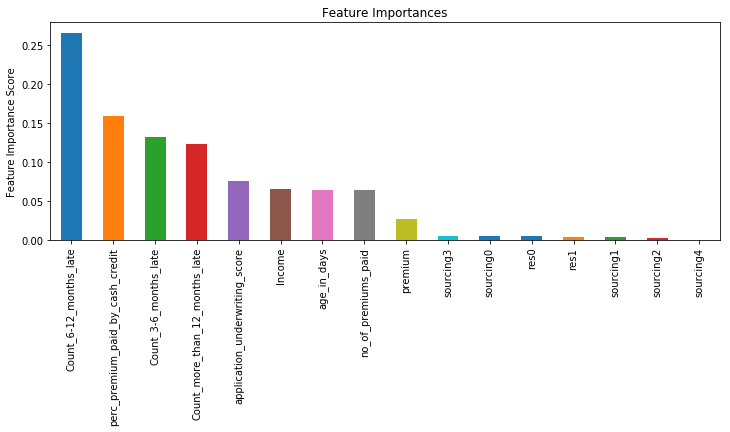

In [103]:
#Reducing learning rate and increasing esimators
GB_model_tuned = GradientBoostingClassifier(learning_rate=0.01,n_estimators=350,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned, X_train, y_train)

Accuracy: 0.9416
AUC score (train): 0.865436
CV score : Mean - 0.8416586 | Std - 0.003372528 | Min - 0.8374895 | Max - 0.8475914


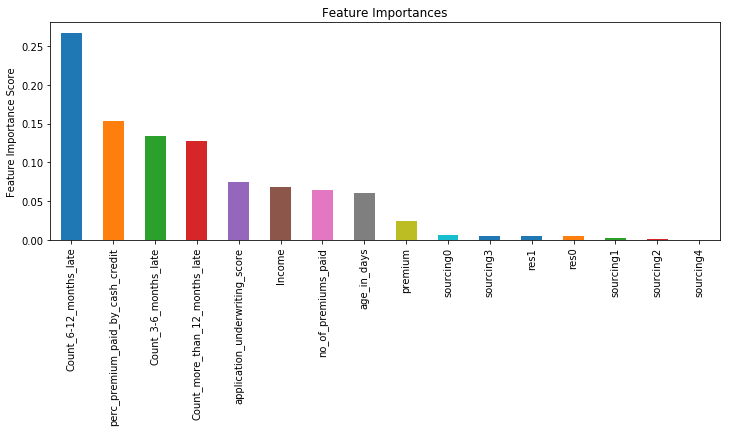

In [106]:
#Reducing learning rate and increasing esimators
GB_model_tuned2 = GradientBoostingClassifier(learning_rate=0.005,n_estimators=700,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned2, X_train, y_train)

Accuracy: 0.9428
AUC score (train): 0.876594


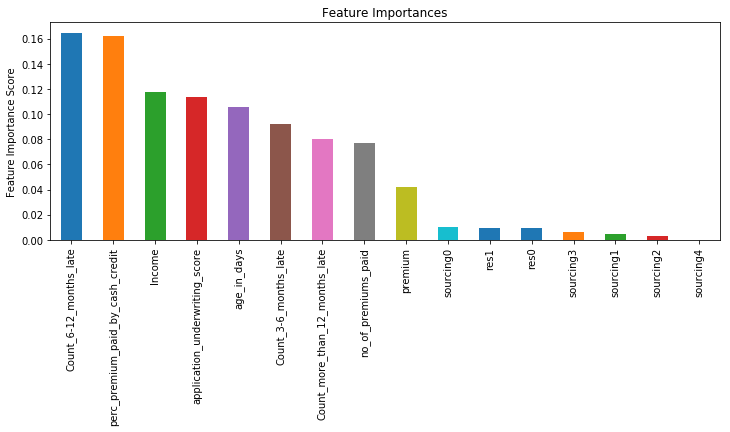

In [107]:
#Reducing learning rate and increasing esimators
GB_model_tuned3 = GradientBoostingClassifier(learning_rate=0.005,n_estimators=1400,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned3, X_train, y_train, performCV=False)

Accuracy: 0.9397
AUC score (train): 0.860842


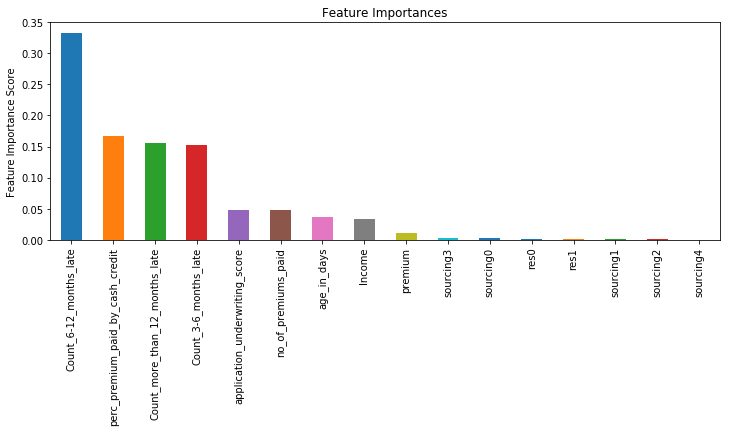

In [110]:
#Reducing learning rate and increasing esimators
GB_model_tuned4 = GradientBoostingClassifier(learning_rate=0.001,n_estimators=2000,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned4, X_train, y_train, performCV=False)

Accuracy: 0.9438
AUC score (train): 0.884741


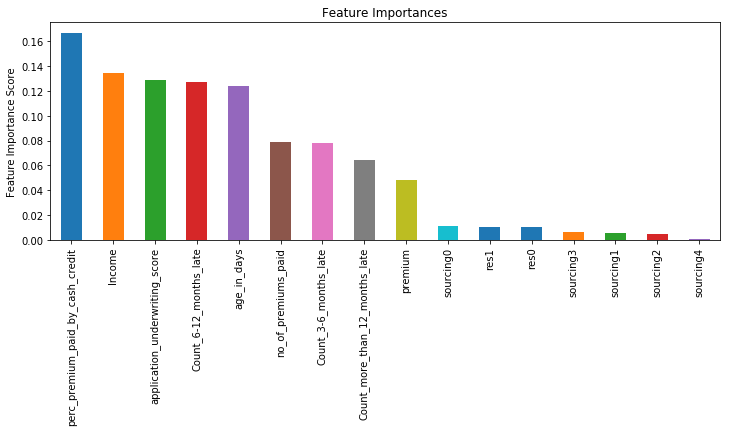

In [207]:
#Reducing learning rate and increasing esimators
GB_model_tuned5 = GradientBoostingClassifier(learning_rate=0.001,n_estimators=10000,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned5, X_train, y_train, performCV=False)

Accuracy: 0.9438
AUC score (train): 0.884777


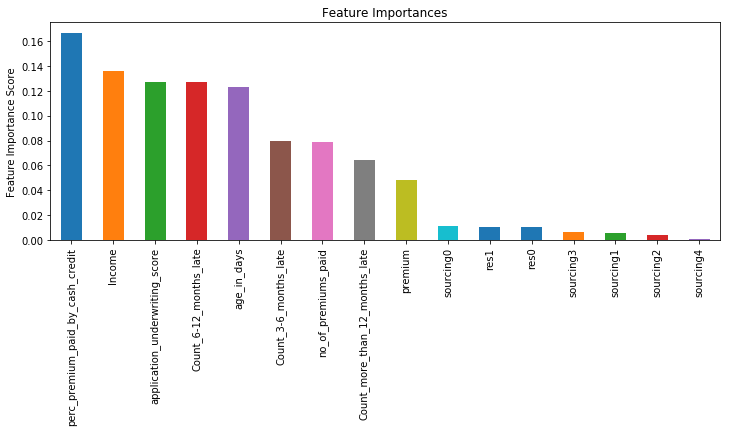

In [24]:
#Reducing learning rate and increasing esimators
GB_model_tuned6 = GradientBoostingClassifier(learning_rate=0.005,n_estimators=2000,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned6, X_train, y_train, performCV=False)

In [205]:
#evaluating model on development set
dev_predictions = GB_model_tuned3.predict(X_dev)
dev_predprob = GB_model_tuned3.predict_proba(X_dev)[:,1]
#evaluate predictions
print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9376
AUC score (dev): 0.843410


In [206]:
#evaluating model on development set
dev_predictions = GB_model_tuned4.predict(X_dev)
dev_predprob = GB_model_tuned4.predict_proba(X_dev)[:,1]
#evaluate predictions
print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.937
AUC score (dev): 0.844771


In [208]:
#evaluating model on development set
dev_predictions = GB_model_tuned5.predict(X_dev)
dev_predprob = GB_model_tuned5.predict_proba(X_dev)[:,1]
#evaluate predictions
print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9378
AUC score (dev): 0.842860


In [25]:
#evaluating model on development set
dev_predictions = GB_model_tuned6.predict(X_dev)
dev_predprob = GB_model_tuned6.predict_proba(X_dev)[:,1]
#evaluate predictions
print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9378
AUC score (dev): 0.842246


In [101]:
# my_mod1 = joblib.load("pima_6_2.joblib.dat")
# #evaluating model on development set
# dev_predictions = my_mod1.predict(X_dev)
# dev_predprob = my_mod1.predict_proba(X_dev)[:,1]
# #evaluate predictions
# print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
# print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9392
AUC score (dev): 0.867339


In [100]:
# my_mod = joblib.load("pima_6_3.joblib.dat")
# #evaluating model on development set
# dev_predictions = my_mod.predict(X_dev)
# dev_predprob = my_mod.predict_proba(X_dev)[:,1]
# #evaluate predictions
# print("Accuracy: %.4g" % accuracy_score(y_dev.values, dev_predictions) )
# print("AUC score (dev): %f" % roc_auc_score(y_dev, dev_predprob))

Accuracy: 0.9391
AUC score (dev): 0.867270


In [103]:
# print(my_mod1)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=220, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=3500,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)


In [88]:
# a = joblib.load("pima_6_1.joblib.dat")
# print(a)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=220, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=4000,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)


In [ ]:
#Perform grid search
param_test_x = {'n_estimators':range(2000,4000,100), 'learning_rate':[0.0001, 0.0003, 0.0005, 0.001]}
gsearch_x = GridSearchCV(estimator=GradientBoostingClassifier(min_samples_split=600,
                                                             min_samples_leaf=220, max_depth=9, max_features='sqrt',
                                                             subsample=0.8, random_state=10),
                        param_grid = param_test_x, scoring = 'roc_auc', n_jobs=4, iid=False, cv=5)
gsearch_x.fit(X_train, y_train)

#### Saving models

In [133]:
# mymod = joblib.load("pima4.joblib.dat")
# print(mymod)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=220, min_samples_split=600,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)


In [287]:
# # save models to file
# joblib.dump(GB_model, "pima.joblib.dat")
# joblib.dump(GB_model_tuned, "pima1.joblib.dat")
# joblib.dump(GB_model_tuned2, "pima2.joblib.dat")
# joblib.dump(GB_model_tuned3, "pima3.joblib.dat")
# joblib.dump(GB_model_tuned4, "pima4.joblib.dat")
# joblib.dump(GB_model_tuned5, "pima5.joblib.dat")
# joblib.dump(gsearch3.best_estimator_, "pima_est.joblib.dat")

['pima_est.joblib.dat']

In [28]:
# joblib.dump(GB_model_tuned6, "pima6.joblib.dat")

['pima6.joblib.dat']

In [293]:
#loaded_model = joblib.load("pima2.joblib.dat")

#### Train best model on all data

In [30]:
#Converting y to 1D array
y = y.squeeze()

Accuracy: 0.9394
AUC score (train): 0.860036


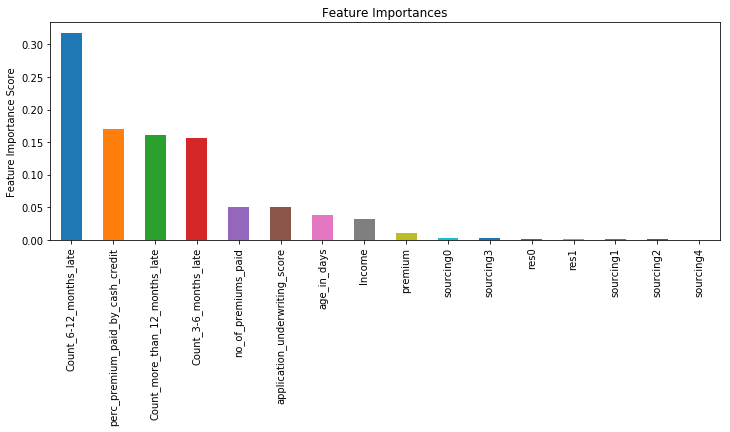

In [31]:
#Reducing learning rate and increasing esimators
GB_model_tuned_final = GradientBoostingClassifier(learning_rate=0.001,n_estimators=2000,max_depth=9, 
                                            min_samples_split=600,min_samples_leaf=220, 
                                            max_features='sqrt',random_state=10, subsample=0.8)
model_fit_gb(GB_model_tuned_final, X, y, performCV=False)

In [32]:
joblib.dump(GB_model_tuned_final, "pima_final.joblib.dat")

['pima_final.joblib.dat']

In [25]:
GB_model_tuned_final = joblib.load('pima_final.joblib.dat')

In [26]:
#using final model to predict on test set
test_predictions = GB_model_tuned_final.predict(X_test)
test_predprob = GB_model_tuned_final.predict_proba(X_test)[:,1]

In [27]:
np.sum(test_predprob > 0.5)

34031

### Incentives plan

In [27]:
#using final model to predict probabilities on training and dev sets
#train_predprob = GB_model_tuned_final.predict_proba(X_train)[:,1]
#dev_predprob = GB_model_tuned_final.predict_proba(X_dev)[:,1]
train_predprob = GB_model_tuned_final.predict_proba(X)[:,1]

In [28]:
#X_train = pd.concat([X_train, pd.DataFrame(train_predprob, columns=['prob_bench']).set_index(X_train.index.values)], axis=1)
#X_dev = pd.concat([X_dev, pd.DataFrame(dev_predprob, columns=['prob_bench']).set_index(X_dev.index.values)], axis=1)
X_total_train = pd.concat([X, pd.DataFrame(train_predprob, columns=['prob_bench']).set_index(X.index.values)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(test_predprob, columns=['prob_bench']).set_index(X_test.index.values)], axis=1)

In [29]:
display(X_total_train.head(), X_test.head())

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing0,sourcing1,sourcing2,sourcing3,sourcing4,res0,res1,prob_bench
id,,,,,,,,,,,,,,,,,
110936.0,0.429,12058.0,355060.0,0.0,0.0,0.0,99.02,13.0,3300.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.959793
41492.0,0.010,21546.0,315150.0,0.0,0.0,0.0,99.89,21.0,18000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.981228
31300.0,0.917,17531.0,84140.0,2.0,3.0,1.0,98.69,7.0,3300.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.416286
19415.0,0.049,15341.0,250510.0,0.0,0.0,0.0,99.57,9.0,9600.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.981583
99379.0,0.052,31400.0,198680.0,0.0,0.0,0.0,99.87,12.0,9600.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.982565


,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,sourcing0,sourcing1,sourcing2,sourcing3,sourcing4,res0,res1,prob_bench
id,,,,,,,,,,,,,,,,,
649.0,0.001,27384.0,51150.0,0.0,0.0,0.0,99.890000,7.0,3300.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.983617
81136.0,0.124,23735.0,285140.0,0.0,0.0,0.0,98.930000,19.0,11700.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.976303
70762.0,1.000,17170.0,186030.0,0.0,0.0,0.0,99.067291,2.0,11700.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.823672
53935.0,0.198,16068.0,123540.0,0.0,0.0,0.0,99.000000,11.0,5400.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.972249
15476.0,0.041,10591.0,200020.0,1.0,0.0,0.0,99.170000,14.0,9600.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.954995


In [30]:
# def net_total_rev(e):
#     df = X_total_train.iloc[:5,:]
#     p1, p2, p3, p4, p5 = df.prob_bench
#     pr1, pr2, pr3, pr4, pr5 = df.premium
#     e1, e2, e3, e4, e5 = e[:5]
#     def net_rev(p, pr, e):
#         return(p*pr*0.04*math.exp(-e/5) - 400/(10-e))
#     r1 = net_rev(p1, pr1, e1)
#     r2 = net_rev(p2, pr2, e2)
#     r3 = net_rev(p3, pr3, e3)
#     r4 = net_rev(p4, pr4, e4)
#     r5 = net_rev(p5, pr5, e5)
#     return(r1,r2,r3,r4,r5)

In [157]:
def net_total_rev(e):
    df = X_total_train
    p = df.prob_bench
    pr = df.premium
    r = []
    def net_rev(p, pr, e):
        return(p*pr*0.04*math.exp(-e/5) - 400/(10-e))
    for i in range(len(df)):
        r.append(net_rev(p.iloc[i], pr.iloc[i], e[i]))
    return(r)

guess = 5
x0 = np.array([guess]*X_total_train.shape[0])
sol = root(net_total_rev, x0, method = 'lm')
#print('effort=5 :', sol.x, sol.success, sol.nfev, np.sum(net_total_rev(sol.x)))
incent = -400*np.log(1-sol.x/10)
incent[incent<0] = 0

In [32]:
list(np.append([],2))

[2.0]

In [41]:
X_test.shape

(34224, 17)

In [ ]:
def net_total_rev_test(e, i):
    df = X_test.iloc[i:i+4,:]
    p = df.prob_bench
    pr = df.premium
    r = np.array([])
    def net_rev(p, pr, e):
        return(p*pr*0.04*math.exp(-e/5) - 400/(10-e))
    for i in range(len(df)):
        r = np.append(r,net_rev(p.iloc[i], pr.iloc[i], e[i]))
    return(r)

In [53]:
incent_test = np.array([])
for i in range(0,X_test.shape[0], 4):
    guess = 5
    x0_test = np.array([guess]*4)
    sol_test = root(net_total_rev_test, x0_test, args=i, method = 'lm')
#print('effort=5 :', sol_test.x, sol_test.success, sol_test.nfev, np.sum(net_total_rev_test(sol_test.x)))
    incent_test_out = -400*np.log(1-sol_test.x/10)
    incent_test_out[incent_test_out<0] = 0
    incent_test = np.append(incent_test, incent_test_out)

incent_df = pd.DataFrame(incent_test, index=X_test.index, columns=['incentive'])
X_test = pd.concat([X_test, incent_df], axis=1)

In [59]:
output = pd.DataFrame({'id':X_test.index.astype('int32'), 'renewal':np.array(X_test.prob_bench), 'incentives':np.array(X_test.incentive)})
output.reindex(columns=['id','renewal','incentives']).set_index('id').to_csv('GBM.csv', sep=",")

In [31]:
# X_total_train['delta_p'] = 100*(1/X_total_train['prob_bench'] - 1)
# X_total_train['delta_p_upper'] = 20*(1-math.exp(-2))

# X_test['delta_p'] = 100*(1/X_test['prob_bench'] - 1)
# X_test['delta_p_upper'] = 20*(1-math.exp(-2))

# X_total_train['del_p_cons'] = X_total_train[['delta_p', 'delta_p_upper']].min(axis=1)
# X_test['del_p_cons'] = X_test[['delta_p', 'delta_p_upper']].min(axis=1)

# display(X_total_train.head(n=2), X_test.head(n=2))

# popped_delta_p_train = X_total_train.pop('delta_p')
# popped_delta_p_upper_train = X_total_train.pop('delta_p_upper')
# popped_delta_p_test = X_test.pop('delta_p')
# popped_delta_p_upper_test = X_test.pop('delta_p_upper')

# display(X_total_train.head(n=2), X_test.head(n=2))

In [ ]:
# def objective(x, sign=-1.0, df = X_total_train):
#     x1 = x[0]
#     x2 = x[1]
#     return sign*(df['prob_bench']*df['premium']*(1+x1/100) + 400*np.log(1-x2/10))

# def constraint1(x, sign=-1.0, df = X_total_train):
#     return -100*(1/df['prob_bench'] - 1) + x[0]

# x0 = [[0,0] for i in range(X_total_train.shape[0])]
# #b1=(np.zeros([X_total_train.shape[0]]),np.ones([X_total_train.shape[0]])*20*(1-math.exp(-2)))
# #b2=(np.zeros([X_total_train.shape[0]]),np.ones([X_total_train.shape[0]])*10)
# #bnds = (b1,b2)

# bnds = [((0,20*(1-math.exp(-2))), (0,10))]*X_total_train.shape[0]
# con1 = {'type': 'ineq', 'fun': constraint1}

# cons = [con1]
# sol = minimize(objective,x0,method='SLSQP',bounds=bnds,constraints=cons)

# print(sol)

#### Implement logistic regression

In [26]:
#set parameters
num_epochs = 10000
minibatch_size = 64
seed = 3
costs = []
learning_rate = 0.001

In [27]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X.iloc[permutation,:]
    shuffled_Y = Y.iloc[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X.iloc[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y.iloc[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X.iloc[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y.iloc[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [28]:
y_train, y_dev = pd.DataFrame(y_train), pd.DataFrame(y_dev)

In [ ]:
#tf Graph Input
X = tf.placeholder(tf.float32, shape=([None, X_train.shape[1]]), name = 'X')
Y = tf.placeholder(tf.float32, shape=[None,1], name = 'y')

#set model weights
#W = tf.Variable(tf.zeros([X_train.shape[1], 1]))
W = tf.get_variable("W", shape=[X_train.shape[1], 1], initializer = tf.random_normal_initializer())
b = tf.Variable(tf.zeros([1]))

#Construct model and minimize error using cross-entropy
Z = tf.matmul(X, W)+b
cost = tf.reduce_mean(tf.squared_difference(Y,Z))

#Backpropagation - optimizer
optimizer = tf.train.AdamOptimizer(beta1=0.9, beta2=0.999,epsilon=1e-08, learning_rate=learning_rate).minimize(cost)

#AUC score
p = tf.cast(tf.argmax(Z,1), tf.float32)
q = tf.cast(tf.argmax(Y,1), tf.float32)
auc = tf.contrib.metrics.streaming_auc(q,p)

In [269]:
tf.reset_default_graph()

#Initialize all variables globally
init = tf.global_variables_initializer()

#Start session to compute the tensorflow graph
with tf.Session() as sess:
    #Run the initialization
    sess.run(init)
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.initialize_local_variables())
    #Do the training loop
    for epoch in range(num_epochs):
        
        minibatch_cost = 0.
        num_minibatches = int(X_train.shape[0] / minibatch_size)
        seed = seed + 1
        minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            _, temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
            
            minibatch_cost += temp_cost / num_minibatches
        
        #Print the cost every epoch
        if epoch %100 == 0:
            print('Cost after epoch %i: %f' % (epoch, minibatch_cost))
        if epoch%1 == 0:
            costs.append(minibatch_cost)
    
    #plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()
    
    #Calculate the correct predictions
    predict_op = tf.argmax(Z,1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y,1))
    
    #Calculate accuracy on dev set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print(accuracy)
    train_accuracy = accuracy.eval({X:X_train, Y:y_train})
    dev_accuracy = accuracy.eval({X:X_dev, Y:y_dev})
    print("Train accuracy:", train_accuracy)
    print("Dev set accuracy:", dev_accuracy)
    
    #Print AUC scores
    train_auc = sess.run(auc, feed_dict={X:X_train, Y:y_train})
    dev_auc = sess.run(auc, feed_dict={X:X_dev, Y:y_dev})
    print("AUC score (train):", train_auc)
    print("AUC score (dev):", dev_auc)